In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from enum import Enum
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
EXPORTS_DIR = '../data/exports'
MATRIX_DIR = '../data/exports/adjacency_matrix'
SHAPEFILE_DIR = '../data/shapefiles/zipcodes'
CENTROIDS_DIR = '../data/exports'
LABELS_DIR = '../data/exports'
STATIONS_DIR = '../data/exports'
CLUSTER = True
K = 25
NODE_TYPE = 'station_id'

DF_INDEX_ALL = 0
DF_INDEX_CLASSIC = 1
DF_INDEX_ELECTRIC = 2

if CLUSTER:
    MATRIX_DIR = f'{MATRIX_DIR}/k{K}'
    NODE_TYPE = 'label'


class AnalysisConfig:
    def __init__(self, shapefile_path='', stations_path='', city_suffix=''):
        self.shapefile_path = shapefile_path
        self.stations_path = stations_path
        self.centroids_path = (
            f'{CENTROIDS_DIR}/centroids_k25_{city_suffix}.csv')
        self.labels_path = (
            f'{LABELS_DIR}/cluster_labels_k25_{city_suffix}.csv')
        self.displacement_matrix_path = (
            f'{MATRIX_DIR}/displacement_{city_suffix}.csv')
        self.elevation_matrix_path = (
            f'{MATRIX_DIR}/elevation_{city_suffix}.csv')
        self.trip_count_classic_matrix_path = (
            f'{MATRIX_DIR}/trip_count_classic_{city_suffix}.csv')
        self.trip_count_electric_matrix_path = (
            f'{MATRIX_DIR}/trip_count_electric_{city_suffix}.csv')
        self.trip_count_matrix_path = (
            f'{MATRIX_DIR}/trip_count_{city_suffix}.csv')
        self.city_suffix = city_suffix

    def get_export_path(self, filename):
        return f'{EXPORTS_DIR}/{filename}_{self.city_suffix}.csv'
    
    def get_nodes_df(self):
        if CLUSTER:
            return pd.read_csv(self.centroids_path).reset_index().rename(columns={
                'index': 'label',
            })
        return pd.read_csv(self.stations_path)


def get_trip_matrix(config, path=None):
    if not path:
        path = config.trip_count_matrix_path
    trip_matrix = pd.read_csv(path, index_col=0)
    trip_matrix.columns = trip_matrix.columns.astype('str')
    trip_matrix.index = trip_matrix.index.astype('str')
    return trip_matrix

In [3]:
config_sf = AnalysisConfig(
    city_suffix = 'sf',
    shapefile_path = f'{SHAPEFILE_DIR}/san_francisco.shp',
    stations_path = f'{STATIONS_DIR}/SF_ele_single station.csv',
)

config_dc = AnalysisConfig(
    city_suffix = 'dc',
    shapefile_path = f'{SHAPEFILE_DIR}/washington_dc.shp',
    stations_path = f'{STATIONS_DIR}/DC_ele_single station.csv',
)

In [4]:
def load_gdfs(config):
    zips_gdf = gpd.read_file(config.shapefile_path)
    nodes_df = config.get_nodes_df()
    nodes_gdf = gpd.GeoDataFrame(
        nodes_df,
        geometry=gpd.points_from_xy(nodes_df['lng'],
                                    nodes_df['lat'])).set_crs('EPSG:4326')
    nodes_gdf[NODE_TYPE] = nodes_gdf[NODE_TYPE].astype('str')
    return (zips_gdf, nodes_gdf)

In [5]:
def normalize_matrix(matrix, max=max, min=0):
    return matrix.sub(min).div(max - min)

In [6]:
def get_labels_df(config):
    return pd.read_csv(config.labels_path, index_col=0)

## Clustered Network Analysis

In [7]:
def get_lat_lng(df, node_id):
    return df[df[NODE_TYPE] == node_id][[
        'lat', 'lng'
    ]].iloc[0][:]

def get_lat_lng_edges(matrix, nodes_gdf):
    node_ids = list(matrix.columns)
    
    def has_node(id):
        return len(nodes_gdf[nodes_gdf[NODE_TYPE] == id]) > 0
    
    edges = pd.DataFrame([], columns=['lat1', 'lng1', 'lat2', 'lng2', 'value'])
    for id1 in node_ids:
        if not has_node(id1):
            continue
            
        lat1, lng1 = get_lat_lng(nodes_gdf, id1)
        
        for id2 in node_ids:
            if id1 == id2 or not has_node(id2):
                continue
                
            lat2, lng2 = get_lat_lng(nodes_gdf, id2)

            edges = edges.append({
                'lat1': lat1,
                'lng1': lng1,
                'lat2': lat2,
                'lng2': lng2,
                'id1': id1,
                'id2': id2,
                'value': matrix[id1][id2],
            }, ignore_index=True)
            
    return edges

In [8]:
def get_sorted_edges(trip_matrix_norm, normalize=True):
    edges = get_lat_lng_edges(trip_matrix_norm, nodes_gdf)
    sorted_edges = edges[edges['value'] > 0].sort_values(by='value')
    if normalize:
        sorted_edges['value'] = sorted_edges['value'] / sorted_edges['value'].max()
    return sorted_edges

In [9]:
edges_all = None
edges_classic = None
edges_electric = None
trip_matrix_all = None
trip_matrix_classic = None
trip_matrix_electric = None


def populate_trip_data(config):
    trip_matrix_all = get_trip_matrix(config, config.trip_count_matrix_path)
    trip_max = trip_matrix_all.max().max()
    trip_matrix_all = normalize_matrix(trip_matrix_all, max=trip_max)
    edges_all = get_sorted_edges(trip_matrix_all)

    trip_matrix_classic = get_trip_matrix(config,
                                          config.trip_count_classic_matrix_path)
    trip_matrix_classic = normalize_matrix(trip_matrix_classic, max=trip_max)
    edges_classic = get_sorted_edges(trip_matrix_classic)

    trip_matrix_electric = get_trip_matrix(
        config, config.trip_count_electric_matrix_path)
    trip_matrix_electric = normalize_matrix(trip_matrix_electric, max=trip_max)
    edges_electric = get_sorted_edges(trip_matrix_electric)
    
    return (
        edges_all,
        edges_classic,
        edges_electric,
        trip_matrix_all,
        trip_matrix_classic,
        trip_matrix_electric,
    )

In [10]:
CRS_PLOT = 'EPSG:4326'

def plot_map(fig, ax, zips_gdf):
    zips_gdf.to_crs({'init': CRS_PLOT}).plot(ax=ax, color=str(0.7), zorder=0)
    
def plot_network(fig, ax, edges, title=''):
    for i, edge in edges.iterrows():
        lat1, lng1, lat2, lng2 = edge[['lat1', 'lng1', 'lat2', 'lng2']]
        # 0.0 = black, 1.0 = white, flip and scale to [0.0, 0.5].
        color = (1 - edge['value']) * 0.25
        alpha = max(edge['value'] * 3, 1)
        linewidth = edge['value'] * 2
        ax.plot([lng1, lng2], [lat1, lat2],
                 'k-',
                 linewidth=linewidth,
                 color=str(color),
                 alpha=alpha,
                 zorder=1)

    ax.set_title(title)
    
def plot_networks():
    fig, ax = plt.subplots(1, 3, figsize=(36, 12))
    edges_list = [edges_all, edges_classic, edges_electric]

    for i in range(0, 3):
        plot_map(fig, ax[i], zips_gdf)
        plot_network(fig, ax[i], edges_list[i])

    plt.show()

In [11]:
def get_flow_df(matrix_path):
    matrix = pd.read_csv(matrix_path).set_index(NODE_TYPE)
    matrix.columns = matrix.columns.astype('str')
    matrix.index = matrix.index.astype('str')
    in_counts = matrix.sum(numeric_only=True)
    out_counts = matrix.sum(axis=1)
    matrix['in'] = in_counts
    matrix['out'] = out_counts
    matrix['diff'] = in_counts - out_counts
    return matrix[['in', 'out', 'diff']]

def get_normalized_column(df, column):
    column_min = df[column].min()
    return (df[column] - column_min) / (df[column].max() - column_min)

def normalize_flow_df(df):
    normalized_df = df.copy()
    normalized_df['in'] = get_normalized_column(df, 'in')
    normalized_df['out'] = get_normalized_column(df, 'out')
    normalized_df['diff'] = get_normalized_column(df, 'diff')
    return normalized_df


In [12]:
zips_gdf = None
nodes_gdf = None
trip_flow_dfs = None
nodes_flow_dfs = None

def populate_dfs(config):
    zips_gdf, nodes_gdf = load_gdfs(config)

    nodes_gdf['count'] = (nodes_gdf['count'] - nodes_gdf['count'].min()) / (
        nodes_gdf['count'].max() - nodes_gdf['count'].min())

    trip_flow_dfs = [
        get_flow_df(config.trip_count_matrix_path),
        get_flow_df(config.trip_count_classic_matrix_path),
        get_flow_df(config.trip_count_electric_matrix_path),
    ]
    
    nodes_flow_gdfs = [
        pd.merge(nodes_gdf, df, on=NODE_TYPE) for df in trip_flow_dfs
    ]
    
    return (zips_gdf, nodes_gdf, trip_flow_dfs, nodes_flow_gdfs)

In [13]:
def plot_nodes(fig,
               ax,
               nodes_gdf,
               column,
               title=None,
               top_n=None,
               bottom_n=None,
               colormap='coolwarm_r',
               marker_size=40):
    all_gdf = nodes_gdf.to_crs({'init': CRS_PLOT}).copy()

    gdfs = []
    if top_n or bottom_n:
        all_gdf = all_gdf.sort_values([column], ascending=False)
        if top_n:
            gdfs.append(all_gdf.iloc[0:top_n, :])
        if bottom_n:
            gdfs.append(all_gdf.iloc[-bottom_n:, :])
    else:
        gdfs.append(all_gdf)

    gdf = pd.concat(gdfs)
    markersize_scaled = nodes_gdf['count'] * marker_size + marker_size
    gdf.plot(ax=ax,
             column=column,
             norm=matplotlib.colors.Normalize(),
             cmap=colormap,
             edgecolors='black',
             markersize=markersize_scaled,
             zorder=2)

    if title:
        ax.set_title(title)

    return fig, ax

In [14]:
def plot_diff_and_elevation(config):
    fig, ax = plt.subplots(1, 4, figsize=(36, 20))

    for i in range(0, 3):
        plot_map(fig, ax[i], zips_gdf)
        plot_network(fig, ax[i], edges_list[i])
        plot_nodes(fig, ax[i], nodes_flow_gdfs[i], 'diff', title=titles[i])

    plot_map(fig, ax[3], zips_gdf)
    plot_network(fig, ax[3], edges_list[0])
    plot_nodes(fig,
               ax[3],
               nodes_flow_gdfs[0],
               'elevation',
               title='Elevation',
               colormap='coolwarm_r')

    for i in range(0, 4):
        ax[i].axis('off')
        ax[i].margins(0)
        ax[i].apply_aspect()

In [15]:
def plot_variable(config, variable, df_index=0):
    FS = 5.0 if config == config_sf else 4.8
    fig, ax = plt.subplots(figsize=(FS, FS))
    edges_list = [edges_all, edges_classic, edges_electric]

    colormap = 'coolwarm' if variable == 'elevation' else 'coolwarm_r'

    plot_map(fig, ax, zips_gdf)
    plot_network(fig, ax, edges_list[df_index])
    plot_nodes(fig,
               ax,
               nodes_flow_gdfs[df_index],
               variable,
               title='',
               colormap=colormap)

    # San Francisco
    if config == config_sf:
        minx, miny, maxx, maxy = zips_gdf.geometry.total_bounds
        dx = maxx - minx
        dy = maxy - miny
        ax.set_xlim(minx + 0 * dx, maxx - 0.1 * dx)
        ax.set_ylim(miny + 0 * dy, maxy - 0.1 * dy)
        ax.set_xticklabels(ax.get_xticklabels()[::3])
        ax.set_xticks(ax.get_xticks()[::3])

    # Washington D.C.
    if config == config_dc:
        minx, miny, maxx, maxy = zips_gdf.geometry.total_bounds
        dx = maxx - minx
        dy = maxy - miny
        ax.set_xlim(minx + 0.075 * dx, maxx - 0.1 * dx)
        ax.set_ylim(miny + 0.1 * dy, maxy - 0.1 * dy)
        ax.set_xticklabels(ax.get_xticklabels()[::2])
        ax.set_xticks(ax.get_xticks()[::2])

    plt.show()

In [16]:
def normalize_cities(variable):
    esf = pd.read_csv(config_sf.stations_path)
    edc = pd.read_csv(config_dc.stations_path)

    min_e = min(edc[variable].min(), esf[variable].min())
    max_e = max(edc[variable].max(), esf[variable].max())

    for nodes_flow_gdf in nodes_flow_gdfs:
        nodes_flow_gdf[variable] = (nodes_flow_gdf[variable] - min_e) / (max_e - min_e)

In [17]:
(
    sf_zips_gdf,
    sf_nodes_gdf,
    sf_trip_flow_dfs,
    sf_nodes_flow_gdfs,
) = populate_dfs(config_sf)

zips_gdf = sf_zips_gdf
nodes_gdf = sf_nodes_gdf
trip_flow_dfs = sf_trip_flow_dfs
nodes_flow_gdfs = sf_nodes_flow_gdfs

normalize_cities('elevation')

(
    sf_edges_all,
    sf_edges_classic,
    sf_edges_electric,
    sf_trip_matrix_all,
    sf_trip_matrix_classic,
    sf_trip_matrix_electric,
) = populate_trip_data(config_sf)

edges_all = sf_edges_all
edges_classic = sf_edges_classic
edges_electric = sf_edges_electric
trip_matrix_all = sf_trip_matrix_all
trip_matrix_classic = sf_trip_matrix_classic
trip_matrix_electric = sf_trip_matrix_electric

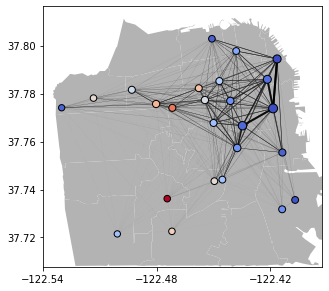

In [18]:
plot_variable(config_sf, 'elevation', DF_INDEX_ALL)

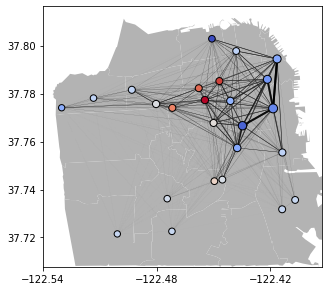

In [19]:
plot_variable(config_sf, 'diff', DF_INDEX_ALL)

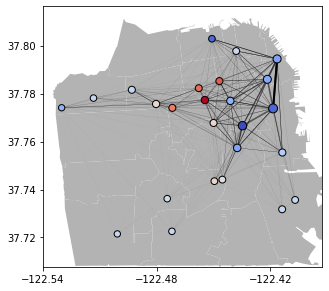

In [20]:
plot_variable(config_sf, 'diff', DF_INDEX_CLASSIC)

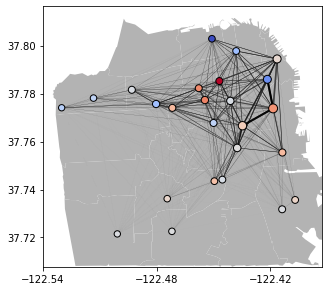

In [21]:
plot_variable(config_sf, 'diff', DF_INDEX_ELECTRIC)

In [22]:
(
    dc_zips_gdf,
    dc_nodes_gdf,
    dc_trip_flow_dfs,
    dc_nodes_flow_gdfs,
) = populate_dfs(config_dc)

zips_gdf = dc_zips_gdf
nodes_gdf = dc_nodes_gdf
trip_flow_dfs = dc_trip_flow_dfs
nodes_flow_gdfs = dc_nodes_flow_gdfs

normalize_cities('elevation')

(
    dc_edges_all,
    dc_edges_classic,
    dc_edges_electric,
    dc_trip_matrix_all,
    dc_trip_matrix_classic,
    dc_trip_matrix_electric,
) = populate_trip_data(config_dc)

edges_all = dc_edges_all
edges_classic = dc_edges_classic
edges_electric = dc_edges_electric
trip_matrix_all = dc_trip_matrix_all
trip_matrix_classic = dc_trip_matrix_classic
trip_matrix_electric = dc_trip_matrix_electric

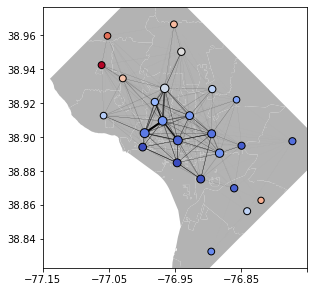

In [23]:
plot_variable(config_dc, 'elevation', DF_INDEX_ALL)

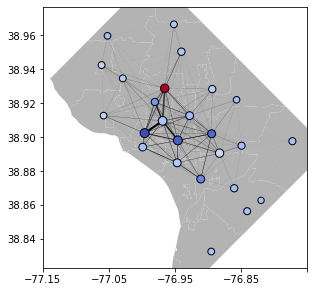

In [24]:
plot_variable(config_dc, 'diff', DF_INDEX_ALL)

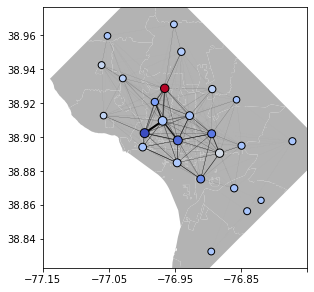

In [25]:
plot_variable(config_dc, 'diff', DF_INDEX_CLASSIC)

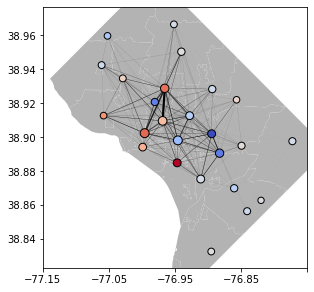

In [27]:
plot_variable(config_dc, 'diff', DF_INDEX_ELECTRIC)

## Hypothesis Testing

In [28]:
def get_trips_from_matrix(matrix):
    node_ids = list(matrix.columns)
    data = []
    for id1 in node_ids:
        for id2 in node_ids:
            if id1 != id2:
                data.append({
                    'id1': id1,
                    'id2': id2,
                    'value': matrix[id1][id2],
                })
    return pd.DataFrame(data)

In [29]:
#trip_matrix_classic = get_trip_matrix(config,
#                                      config.trip_count_classic_matrix_path)
#trip_matrix_classic = normalize_matrix(trip_matrix_classic, max=trip_max)
#edges_classic = get_sorted_edges(trip_matrix_classic, normalize=False)
#
#trip_matrix_electric = get_trip_matrix(config,
#                                       config.trip_count_electric_matrix_path)
#trip_matrix_electric = normalize_matrix(trip_matrix_electric, max=trip_max)
#edges_electric = get_sorted_edges(trip_matrix_electric, normalize=False)

In [37]:
def get_merged_edges(config, edges_classic, edges_electric, matrix_path, variable):
    matrix = get_trip_matrix(config, matrix_path)
    matrix = normalize_matrix(matrix,
                              max=matrix.max().max(),
                              min=matrix.min().min())
    elevations_df = get_trips_from_matrix(matrix)

    edges_classic = pd.merge(edges_classic, elevations_df,
                             on=['id1', 'id2']).rename(columns={
                                 'value_x': 'value',
                                 'value_y': variable,
                             }).sort_values([variable])

    edges_electric = pd.merge(edges_electric, elevations_df,
                              on=['id1', 'id2']).rename(columns={
                                  'value_x': 'value',
                                  'value_y': variable,
                              }).sort_values([variable])

    return (edges_classic, edges_electric)

In [38]:
def plot_hist(fig, ax, df, x, y, color):
    df = df[[x, y]].sort_values(x)
    ax.hist(df[x], bins=100, color=color)
    ax.set_xlabel(x)
    ax.set_ylabel('trips')

In [42]:
def plot_and_test(config, variable, matrix_path):
    merged_edges_classic, merged_edges_electric = get_merged_edges(
        config, edges_classic, edges_electric, matrix_path, variable)

    fig, ax = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    plot_hist(fig, ax[0], merged_edges_classic, variable, 'value', 'C0')
    plot_hist(fig, ax[1], merged_edges_electric, variable, 'value', 'C1')
    plt.show()

    print(variable)
    display(
        stats.ttest_ind(merged_edges_classic['value'],
                        merged_edges_electric['value']))
    display(
        stats.ks_2samp(merged_edges_classic['value'],
                       merged_edges_electric['value']))

In [43]:
zips_gdf = sf_zips_gdf
nodes_gdf = sf_nodes_gdf
trip_flow_dfs = sf_trip_flow_dfs
nodes_flow_gdfs = sf_nodes_flow_gdfs
edges_all = sf_edges_all
edges_classic = sf_edges_classic
edges_electric = sf_edges_electric
trip_matrix_all = sf_trip_matrix_all
trip_matrix_classic = sf_trip_matrix_classic
trip_matrix_electric = sf_trip_matrix_electric

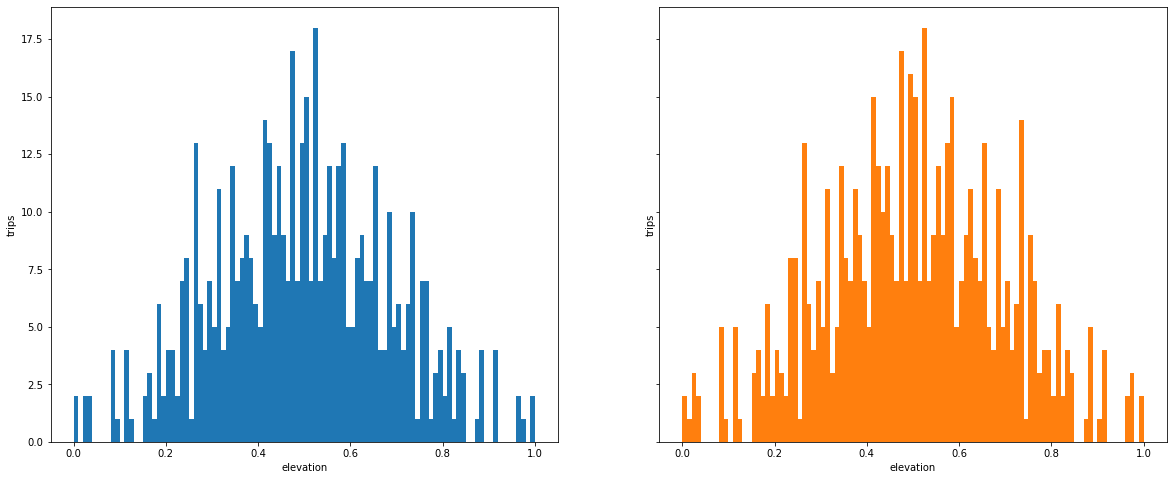

elevation


Ttest_indResult(statistic=-5.129248625393671, pvalue=3.443783337630556e-07)

KstestResult(statistic=0.18789543281456617, pvalue=7.320426043122552e-09)

In [45]:
plot_and_test(config_sf, 'elevation', config_sf.elevation_matrix_path)

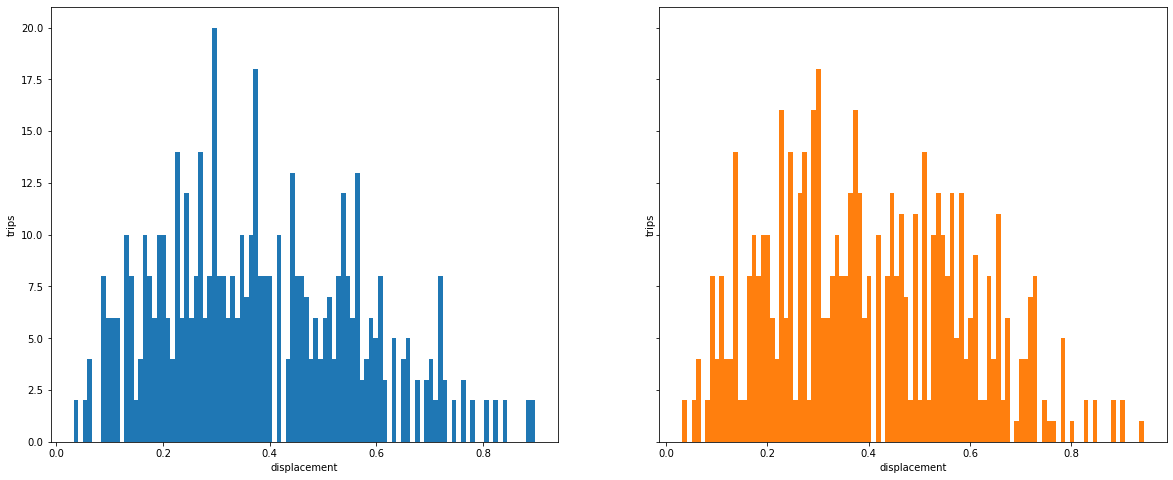

displacement


Ttest_indResult(statistic=-5.129248625393672, pvalue=3.4437833376305186e-07)

KstestResult(statistic=0.18789543281456617, pvalue=7.320426043122552e-09)

In [46]:
plot_and_test(config_sf, 'displacement', config_sf.displacement_matrix_path)

In [47]:
zips_gdf = dc_zips_gdf
nodes_gdf = dc_nodes_gdf
trip_flow_dfs = dc_trip_flow_dfs
nodes_flow_gdfs = dc_nodes_flow_gdfs
edges_all = dc_edges_all
edges_classic = dc_edges_classic
edges_electric = dc_edges_electric
trip_matrix_all = dc_trip_matrix_all
trip_matrix_classic = dc_trip_matrix_classic
trip_matrix_electric = dc_trip_matrix_electric

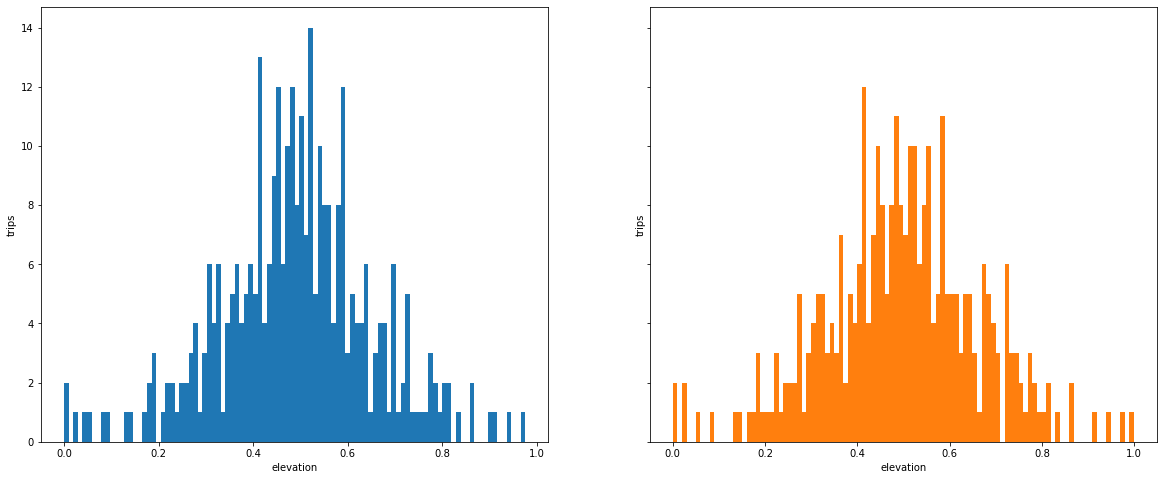

elevation


Ttest_indResult(statistic=-1.5000642261180925, pvalue=0.1340979270692637)

KstestResult(statistic=0.31076923076923074, pvalue=5.029310301551959e-14)

In [48]:
plot_and_test(config_dc, 'elevation', config_dc.elevation_matrix_path)

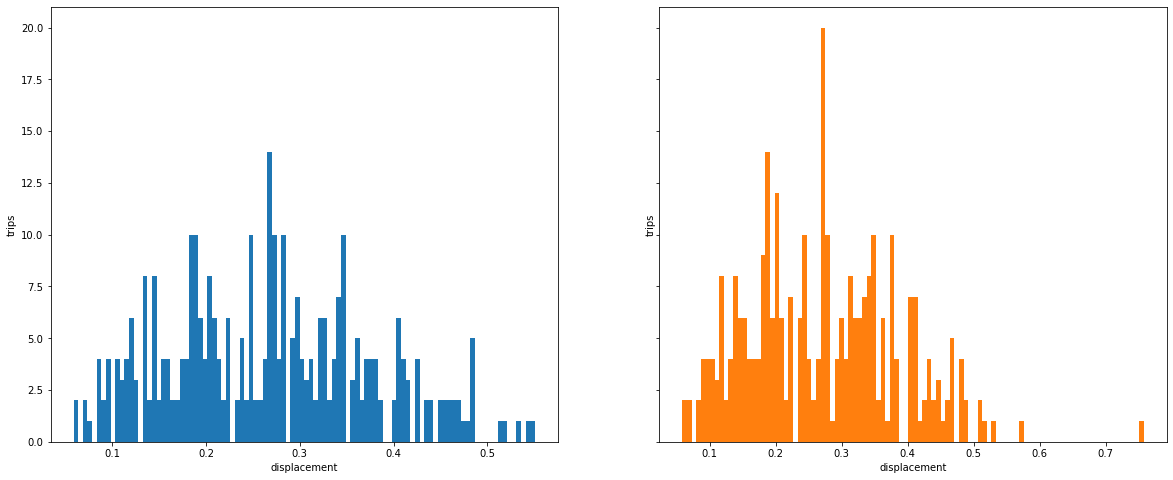

displacement


Ttest_indResult(statistic=-1.5000642261180939, pvalue=0.1340979270692634)

KstestResult(statistic=0.31076923076923074, pvalue=5.029310301551959e-14)

In [49]:
plot_and_test(config_dc, 'displacement', config_dc.displacement_matrix_path)